## Code for all tables and figures of GWAS analysis

In [1]:
import pandas as pd
import numpy as np 
from bed_reader import open_bed, sample_file
import time
import re
import os
import math 
import itertools as itertools
from itertools import product
import statsmodels.stats.multitest
from scipy.stats import norm
from scipy.sparse import lil_matrix
from scipy.io import savemat, loadmat
from scipy.linalg import inv
# Using R inside python
import rpy2
import rpy2.robjects as robjects
from rpy2.robjects import pandas2ri
from rpy2.robjects.vectors import FloatVector
# Set working directory
os.chdir("E:\\GWAS\\plink_win64_20231211")  ## Set directory where required files are stored
# Defining the R script and loading the instance in Python
r = robjects.r
r['source']('sun_cai(2007)_est.R')

# Loading the functions for sun and cai method defined in R.
est_sun_cai_r = robjects.globalenv['epsest.func']   #### function for estimating $\pi$

rej_sun_cai_r = robjects.globalenv['adaptZ.funcnull']

lcfdr_sun_cai_r = robjects.globalenv['adaptZ.funcnulllcfdr']
def locFDRS_GWAS_thread(Z,scov,B,b,pi,tau):
    K = np.size(Z);
    locFDR = np.zeros(K);
    for i in range(K):
        Z_sub = Z[max(i-B,0):(min(i+B,K-1)+1)];
        cov_sub = scov[max(i-B,0):(min(i+B,K-1)+1),max(i-B,0):(min(i+B,K-1)+1)].toarray();
        l = min(i+B,K-1) - max(i-B,0) + 1;
        H = product([0,1], repeat=l);                                           
        sum1 = sum2 = 0;
        for s in H:
            if(s[min(B,i)] == 0): 
                t = ((np.exp(-(1/2)*np.dot(np.inner((Z_sub - np.multiply(s,b)), 
                                         np.linalg.inv(cov_sub+np.multiply(np.diag(s),pow(tau,2)))),
                                  (Z_sub - np.multiply(s,b))))* 
                pow(pi,sum(s)) * pow(1-pi,l-sum(s)))/np.sqrt(np.linalg.det(cov_sub+np.multiply(np.diag(s),pow(tau,2)))));
                sum1 = sum1 + t;
                sum2 = sum2 + t;
            else:
                sum2 = sum2 + ((np.exp(-(1/2)*np.inner(np.dot(Z_sub - np.multiply(s,b), 
                                         np.linalg.inv(cov_sub+np.multiply(np.diag(s),pow(tau,2)))),
                                  (Z_sub - np.multiply(s,b))))* 
               pow(pi,sum(s)) * pow(1-pi,l-sum(s)))/np.sqrt(np.linalg.det(cov_sub+np.multiply(np.diag(s),pow(tau,2)))));
        locFDR[i]= sum1/sum2;
  
  
    return(locFDR);
def rejected(p_val,level):
    oo = np.argsort(p_val);
    ss = np.sort(p_val);
    stat = np.divide(np.cumsum(ss),np.arange(1,np.size(ss)+1,1));
    collection = np.where(stat <= level);
    return(oo[collection]);

## Estimating approximate local false discovery rates ($locFDR_N$) upto $N=3$

In [132]:
matresult = [];
zall = [];
lcfdrscall = [];
lcfdr0all = [];
lcfdr1all = [];
lcfdr2all = [];
lcfdr3all = [];
alpha=0.05;
for chno in np.arange(1,23):
    loaded = np.load(f'zJp_chr{chno}.npz');
    Z = [loaded[f'arr_{i}'] for i in range(len(loaded.files))] ;
    loaded = loadmat(f'ScovJp_chr{chno}.mat');
    ScovJ = [loaded[f'matrix_{i}'] for i in range(len(loaded)-3)];
    zallch = np.array([]);
    lcfdrsc = np.array([]);
    lcfdr0 = np.array([]);
    lcfdr1 = np.array([]);
    lcfdr2 = np.array([]);
    lcfdr3 = np.array([]);
    for j in range(len(Z)):
        zscore = Z[j];
        zallch = np.append(zallch,zscore);
        pi_est = max(est_sun_cai_r(FloatVector(zscore),0.,1.)+0.001)
        print(pi_est)
        print(np.size(zscore));lsc = np.array(lcfdr_sun_cai_r(FloatVector(zscore)));
        lcfdrsc = np.append(lcfdrsc,lsc);
        print(np.size(lsc))
        
        maxiter =100;
        B = 1;
        est = np.zeros(2);
        for i in range(B):
            est_mat = np.zeros(2*maxiter).reshape(maxiter ,2)
            # z = zscore[10*np.arange(3000)+i];
            z=zscore
            scovest = scovJ = lil_matrix((np.size(z), np.size(z)));
            scovest.setdiag(np.ones(np.size(z)),0);
            b_ini = np.mean(z)/pi_est; tausq_ini = np.amax([0.,(np.var(z)-1-(pow(b_ini,2)*(1-pow(pi_est,2))))/pi_est]); 
            est_mat[0,0] = b_ini; est_mat[0,1] = tausq_ini;
            for iter in 1+np.arange(maxiter-1):
              print(iter);
              p_tau = 1-locFDRS_GWAS_thread(z,scovest,0,b_ini,pi_est,np.sqrt(tausq_ini));
              #pi_next = np.mean(p_tau);
              b_next = (np.sum((p_tau)*z)/max(np.sum((p_tau)),0.01));
              tausq_next = np.amax([0,(np.sum((p_tau)*pow(z-b_next,2))
              /max(np.sum((p_tau)),0.01))-1]);
              b_ini = b_next; tausq_ini = tausq_next;
              est_mat[iter,0] = b_ini; est_mat[iter,1] = tausq_ini;
              if np.amax(abs(est_mat[iter,:]-est_mat[iter-1,:])) < pow(10,-5):
                 print(est_mat[iter,:]);
                 break;
            est = est+est_mat[iter,:]
        print(est/B);
        lcfdr0 = np.append(lcfdr0,locFDRS_GWAS_thread(Z[j], ScovJ[j],0, b_next, pi_est, np.sqrt(tausq_next)));
        lcfdr1 = np.append(lcfdr1,locFDRS_GWAS_thread(Z[j], ScovJ[j],1, b_next, pi_est, np.sqrt(tausq_next)));
        lcfdr2 = np.append(lcfdr2,locFDRS_GWAS_thread(Z[j], ScovJ[j],2, b_next, pi_est, np.sqrt(tausq_next)));
        lcfdr3 = np.append(lcfdr3,locFDRS_GWAS_thread(Z[j], ScovJ[j],3, b_next, pi_est, np.sqrt(tausq_next)));
    result = np.array([np.size(np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zallch))), 
                                                   alpha=(alpha/(1-0.)), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]),np.size(np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zallch))), 
                                                   alpha=(alpha/(1-max(est_sun_cai_r(FloatVector(zallch),0.,1.)+0.))), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]),np.size(rejected(lcfdrsc,alpha)),np.size(rejected(lcfdr0,alpha)),np.size(rejected(lcfdr1,alpha)),np.size(rejected(lcfdr2,alpha)),np.size(rejected(lcfdr3,alpha))]);
    matresult.append(result);
    zall = np.append(zall,zallch);
    lcfdrscall = np.append(lcfdrscall,lcfdrsc)
    lcfdr0all = np.append(lcfdr0all,lcfdr0)
    lcfdr1all = np.append(lcfdr1all,lcfdr1)
    lcfdr2all = np.append(lcfdr2all,lcfdr2)
    lcfdr3all = np.append(lcfdr3all,lcfdr3)

0.16506134950848939
3852
3852
1
2
3
4
5
6
7
8
9
10
11
12
13
14
[0.17457317 1.45394906]
[0.17457317 1.45394906]
0.11977414380947726
3724
3724
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
[0.27397165 1.6689286 ]
[0.27397165 1.6689286 ]
0.10930081519388657
3454
3454
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
[0.39316009 1.33784176]
[0.39316009 1.33784176]
0.1593218599732792
3751
3751
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
[0.31183044 0.86049942]
[0.31183044 0.86049942]
0.16059690494872547
3636
3636
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
[0.23584751 1.34306726]
[0.23584751 1.34306726]
0.10919856241672221
3494
3494
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
[0.29237525 1.87953384]
[0.29237525 1.87953384]
0.116983

## Chromose Wise Analysis Results

In [134]:
matresult

[array([32, 32, 50, 51, 57, 69, 72]),
 array([24, 29, 43, 42, 45, 50, 55]),
 array([18, 23, 34, 36, 37, 41, 51]),
 array([24, 25, 40, 36, 43, 42, 41]),
 array([33, 36, 52, 55, 59, 64, 64]),
 array([21, 23, 37, 36, 45, 48, 49]),
 array([19, 22, 32, 29, 33, 36, 37]),
 array([12, 13, 28, 22, 27, 27, 29]),
 array([25, 27, 39, 39, 36, 37, 42]),
 array([ 6,  6, 18, 17, 22, 25, 31]),
 array([15, 17, 26, 26, 30, 31, 33]),
 array([23, 27, 39, 37, 42, 50, 56]),
 array([ 8, 14, 19, 13, 15, 16, 18]),
 array([ 3,  3, 13,  9,  8, 13, 13]),
 array([21, 21, 34, 38, 43, 47, 50]),
 array([ 3,  5, 15, 16, 15, 18, 17]),
 array([12, 15, 21, 25, 28, 35, 39]),
 array([16, 17, 26, 29, 28, 27, 27]),
 array([34, 35, 40, 41, 47, 49, 51]),
 array([11, 15, 19, 23, 29, 33, 31]),
 array([ 2,  2,  9,  7, 11, 11, 13]),
 array([0, 0, 3, 1, 1, 1, 0])]

In [154]:
# column_names = ["BH", "ABH", "Sun&Cai","$\hat{T}_0$","$\hat{T}_1$","$\hat{T}_2$","$\hat{T}_3$"]
matrix = pd.DataFrame(matresult, index=row_names)
matrix

,0,1,2,3,4,5,6
chr1,32,32,50,51,57,69,72
chr2,24,29,43,42,45,50,55
chr3,18,23,34,36,37,41,51
chr4,24,25,40,36,43,42,41
chr5,33,36,52,55,59,64,64
chr6,21,23,37,36,45,48,49
chr7,19,22,32,29,33,36,37
chr8,12,13,28,22,27,27,29
chr9,25,27,39,39,36,37,42
chr10,6,6,18,17,22,25,31


In [156]:
matrix.to_csv('chromosewise_rejectionsp_het.csv')

In [136]:
# Function to save DataFrame as an image
def save_table_as_image(dataframe, filename="table_image.png"):
    fig, ax = plt.subplots(figsize=(6, 2))  # Adjust the figure size as needed
    ax.axis('off')  # Hide the axes

    # Render the table
    table = ax.table(cellText=dataframe.values, colLabels=dataframe.columns, cellLoc='center', loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.2)  # Adjust the scaling for better readability
    
    # Save as image
    plt.savefig(filename, bbox_inches='tight', dpi=300)

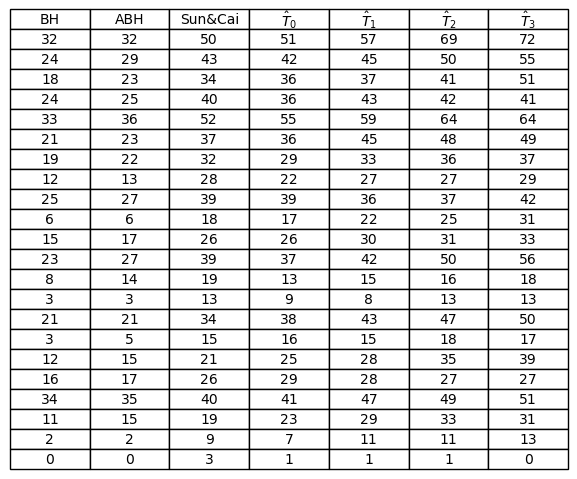

In [138]:
column_names = ["BH","ABH","Sun&Cai","$\hat{T}_0$","$\hat{T}_1$","$\hat{T}_2$","$\hat{T}_3$"]
row_names = [];
for chn in np.arange(1,23):
    row_names.append(f'chr{chn}')

# Create the DataFrame (matrix)
matrix = pd.DataFrame(matresult, index=row_names)
matrix.columns = column_names
# Save the DataFrame as an image
save_table_as_image(matrix, "chrwise_rej_het.png")

## Upset Plot of rejections combined all chromosomes

In [142]:
print(np.size(np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zall))), 
                                                   alpha=(alpha/(1-0.)), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]))
print(np.size(np.where(statsmodels.stats.multitest.multipletests(2*(1-norm.cdf(abs(zall))), 
                                                   alpha=(alpha/(1-max(est_sun_cai_r(FloatVector(zall),0.,1.)+0.))), method='fdr_bh', 
                                                         is_sorted=False, returnsorted=False)[0]==True)[0]))
print(np.size(rejected(lcfdrscall,0.05)))
print(np.size(rejected(lcfdr0all,0.05)))
print(np.size(rejected(lcfdr1all,0.05)))
print(np.size(rejected(lcfdr2all,0.05)))
print(np.size(rejected(lcfdr3all,0.05)))

344
403
654
644
719
788
838


In [152]:
os.getcwd()

'E:\\GWAS\\plink_win64_20231211'

In [54]:
def rejected(p_val,level):
    oo = np.argsort(p_val);
    ss = np.sort(p_val);
    stat = np.divide(np.cumsum(ss),np.arange(1,np.size(ss)+1,1));
    collection = np.where(stat <= level);
    return(ss[collection]);

In [56]:
rejT0 = np.where(lcfdr0all<=rejected(lcfdr0all,alpha)[-1])[0]
rejT1 = np.where(lcfdr1all<=rejected(lcfdr1all,alpha)[-1])[0]
rejT2 = np.where(lcfdr2all<=rejected(lcfdr2all,alpha)[-1])[0]
rejT3 = np.where(lcfdr3all<=rejected(lcfdr3all,alpha)[-1])[0]
rejsc = np.where(lcfdrscall<=rejected(lcfdrscall,alpha)[-1])[0]

In [52]:
rejT0

array([     0,      1,      2, ..., 486570, 486571, 486572], dtype=int64)

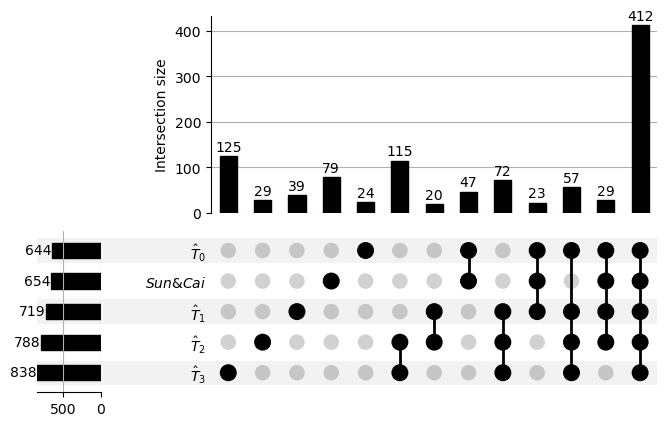

In [58]:
import upsetplot
import matplotlib.pyplot as plt
from upsetplot import from_contents
import warnings

warnings.filterwarnings("ignore")

animals = from_contents(
    {"$\hat{T}_0$": rejT0, "$\hat{T}_1$": rejT1, "$\hat{T}_2$": rejT2, "$\hat{T}_3$": rejT3, "$Sun&Cai$": rejsc}
)
from upsetplot import UpSet

ax_dict = UpSet(animals, subset_size="count",min_subset_size=15,show_counts=True).plot()
plt.savefig('upsetplot_rejectionsp_het.png', dpi=300)

## Finding those 125 independently associated SNPs


In [60]:
ChWiseRej = np.array([]);
for chno in np.arange(1,23):
    Z = np.array(pd.read_csv(f'zlcfdrsp_chr{chno}.csv',header=None));
    ChWiseRej = np.append(ChWiseRej,np.repeat(chno,Z.shape[0]));

In [112]:
ChWiseRej

array([ 1.,  1.,  1., ..., 22., 22., 22.])

In [66]:
# Union of all sets
all_elements =  set(rejsc) | set(rejT0) | set(rejT1) | set(rejT2) | set(rejT3) 

# Intersection of A with the complements of the other sets
onlyT3 =  all_elements - set(rejsc) & all_elements - set(rejT0) & all_elements - set(rejT1) & all_elements - set(rejT2) & set(rejT3)
onlyT3 = np.array(list(onlyT3))
ChWiseRej[onlyT3]

array([ 8.,  6.,  2.,  5.,  6.,  9.,  2.,  1., 13., 19., 19., 10., 17.,
       10.,  2., 10.,  4.,  1.,  8., 17.,  1., 12.,  3.,  1., 12., 12.,
       17.,  5.,  3., 18., 11., 11., 12.,  1., 10.,  1., 15., 21.,  5.,
       19.,  9.,  3.,  3.,  5., 13.,  8., 10.,  9.,  3.,  7.,  2., 12.,
        9.,  8.,  5.,  7., 12.,  3.,  7., 14.,  5.,  7., 11., 10.,  3.,
       14., 18.,  2., 20., 15., 13., 10.,  9.,  2.,  7.,  2., 14.,  3.,
       10., 21., 20., 17.,  4., 16., 12.,  1., 17.,  5., 19.,  9.,  1.,
       16.,  7.,  9., 21., 20.,  6., 10.,  6.,  4., 17.,  8., 22.,  3.,
       22.,  1.,  1., 17., 12.,  6., 22., 12.,  1.,  7.,  2.,  2., 18.,
        2., 17.,  9.,  1., 11.,  2., 16., 10.])

In [68]:
Chridrej = ChWiseRej[rejT3]
Chridrejno = np.array([]);
for chno in range(1,23):
    Chridrejno = np.append(Chridrejno,np.size(np.where(Chridrej == chno)));

In [70]:
Chridrejno

array([78., 58., 49., 40., 62., 52., 37., 32., 43., 32., 36., 55., 22.,
       20., 42., 20., 39., 28., 43., 32., 13.,  5.])

In [76]:
Chridrejuno

array([12., 11.,  9.,  3.,  7.,  5.,  7.,  5.,  8., 10.,  4.,  9.,  3.,
        3.,  2.,  3.,  8.,  3.,  4.,  3.,  3.,  3.])

In [78]:
from scipy.io import savemat, loadmat

In [80]:
rsidsall = np.array([]);
for  chno in range(1,23):
    loaded = np.load(f'rsidlistp_chr{chno}.npz')
    Rsid = [loaded[f'arr_{i}'] for i in range(len(loaded.files))]  
    for rsid in Rsid:
        rsidsall = np.append(rsidsall,rsid);

In [82]:
onlyT3rsid = rsidsall[onlyT3];

In [84]:
np.save('onlyT3rsid_het.npy', onlyT3rsid)

In [86]:
load = np.load('onlyT3rsid_het.npy')

In [92]:
load ### 125 independently associated SNPs by T3 statistics

array(['rs3802266', 'rs55903909', 'rs6714546', 'rs116302901', 'rs220003',
       'rs17082869', 'rs6739218', 'rs12073069', 'rs9515169', 'rs17254556',
       'rs12979773', 'rs1171619', 'rs28760438', 'rs12569940',
       'rs75145077', 'rs7094463', 'rs73819719', 'rs4951067', 'rs10101716',
       'rs1431318', 'rs511599', 'rs35277588', 'rs10934882', 'rs144712473',
       'rs12314162', 'rs12426238', 'rs11654879', 'rs75073573',
       'rs12494525', 'rs7232395', 'rs35903991', 'rs74050111', 'rs7978874',
       'rs11548323', 'rs1044322', 'rs12739678', 'rs7170035', 'rs372563',
       'rs76832821', 'rs72999181', 'rs12684650', 'rs7652177', 'rs6792408',
       'rs11242390', 'rs9545018', 'rs34297248', 'rs3802569', 'rs1858838',
       'rs9857967', 'rs80186772', 'rs16860450', 'rs12424086', 'rs966097',
       'rs1427254', 'rs16821', 'rs10225292', 'rs55747855', 'rs116670060',
       'rs80204349', 'rs17792664', 'rs1368380', 'rs6461556', 'rs57506806',
       'rs73336294', 'rs62244392', 'rs1294542', 'rs34143